In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Given that Beta is the conjugate prior of the binomial distribution, we don't have to run MCMC. We can use the built-in posterior Beta function, resulting from the conjugate relationship, and sample from there. (Although our observable data ~ Bernoulli distribution, we do not know the 'true' parameter value of p. That's why we use Beta distribution to describe the prior for parameter p in order to estimate the true p value)

* if my prior is Beta(α_0, β_0) and I observe N trials and X successes, then my posterior Beta is Beta(α_0 + X, β_0 + n1+n2+n3...nm - X). 
* if my prior is Beta(α_0, β_0) and I observe N=1 trial and X successes, then my posterior Beta is Beta(α_0 + X, β_0 + n - X)

The Bernoulli distribution is a special case of the binomial distribution where a single experiment/trial is conducted (n=1).

# Use Bernoulli because we have only one trial
Let's compare two web pages for the same organization, and analyze the probabilibty of conversions (sign-ups to memberships) for each web page. 

In [2]:
from scipy.stats import beta
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

# beta priors for the bernoulli likelihood
alpha_prior = 1
beta_prior = 1

#Posterior probability based on Bernoulli  likelihood
posterior_A = beta(alpha_prior + conversions_from_A, 
                   beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B, 
                   beta_prior + visitors_to_B - conversions_from_B)

In [3]:
samples = 3000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

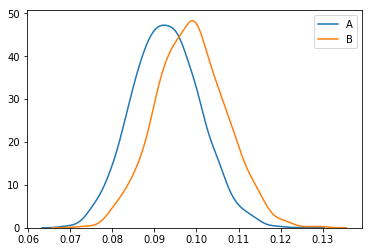

In [6]:
sns.kdeplot(samples_posterior_A, label='A')
sns.kdeplot(samples_posterior_B, label='B')
plt.show()

In [7]:
print ("Probability that site A has higher conversion rates then site B:")
print((samples_posterior_A > samples_posterior_B).mean())
print("\nThis is not very significant considering that if site B and site A were identical webpages and design, \
we would have gotten a probability close to 50%")

Probability that site A has higher conversion rates then site B:
0.29833333333333334

This is not very significant considering that if site B and site A were identical webpages and design, we would have gotten a probability close to 50%


#  Use **Binomial**, as we have two trials (e.g. visitors on two separate months)

In [8]:
from scipy.stats import beta
visitors_to_A = [1300, 1400]
visitors_to_B = [1275, 1150]

conversions_from_A = [120,130]
conversions_from_B = [125, 110]

# beta priors for the binomial likelihood 
alpha_prior = 1
beta_prior = 1

#Posterior probability based on Binomial  likelihood
posterior_A = beta(alpha_prior + (conversions_from_A[0] + conversions_from_A[1]), 
                   beta_prior + (visitors_to_A[0] + visitors_to_A[1]) - (conversions_from_A[0]+conversions_from_A[1]))
posterior_B = beta(alpha_prior + (conversions_from_B[0] + conversions_from_B[1]), 
                   beta_prior + (visitors_to_B[0] + visitors_to_B[1]) - (conversions_from_B[0]+conversions_from_B[1]))

In [9]:
samples = 3000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

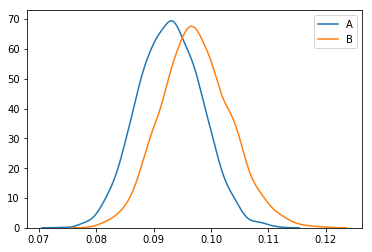

In [10]:
sns.kdeplot(samples_posterior_A, label='A')
sns.kdeplot(samples_posterior_B, label='B')
plt.show()

In [11]:
print ("Probability that site A has higher conversion rates then site B:")
print((samples_posterior_A > samples_posterior_B).mean())

Probability that site A has higher conversion rates then site B:
0.295


# Running MCMC with Bernoulli likelihood
* Because the Beta and the Binomial/Bernoulli priors are conjugates we don't need to run MCMC, but if we wanted to, this is how it would look like

In [12]:
# create array with 0's for visitors to website A that didn't sign-up and 1's for visitors that signed-up
site_A = np.zeros(1300-120)
site_A_sign_ups = np.insert(site_A, np.random.randint(low=0,high=120,size=120), 1) 
site_A_sign_ups = site_A_sign_ups.astype(int)

# create array with 0's for visitors to website B that didn't sign-up and 1's for visitors that signed-up
site_B = np.zeros(1275-125)
site_B_sign_ups = np.insert(site_B, np.random.randint(low=0,high=125,size=125), 1) 
site_B_sign_ups = site_B_sign_ups.astype(int)

print(len(site_B_sign_ups))
print(len(site_B_sign_ups[site_B_sign_ups==1]))
print(len(site_A_sign_ups))
print(len(site_A_sign_ups[site_A_sign_ups==1]))

1275
125
1300
120


In [19]:
with pm.Model() as model:
    priors_site_A = pm.Beta('priors_site_A',alpha=1, beta=1)
    priors_site_B = pm.Beta('priors_site_B',alpha=1, beta=1)
    
    # The relative increase of conversion rates between site B and A
    delta = pm.Deterministic("delta", (priors_site_B - priors_site_A) / priors_site_A)

    obs_A = pm.Bernoulli('obs_A', p=priors_site_A, observed=site_A_sign_ups)
    obs_B = pm.Bernoulli('obs_B', p=priors_site_B, observed=site_B_sign_ups)
    
    # if we were to use a Binomial likelihood because there were more than 1 trial: 
    # obs_A = pm.Binomial('obs_A', n=#of_trials, p=priors_site_A, observed=site_A_sign_ups)

    trace_bernoulli = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [priors_site_B_logodds__, priors_site_A_logodds__]


In [20]:
pm.summary(trace_bernoulli)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
priors_site_A,0.092984,0.008262,0.000077,0.077377,0.109613,10020.652233,0.999910
priors_site_B,0.098708,0.008360,0.000088,0.082782,0.115298,9765.263310,1.000106
delta,0.070011,0.132109,0.001256,-0.171416,0.342903,9774.760266,1.000039


The delta ilustrates that site B is, on average, only 1/2 a percent better than site A

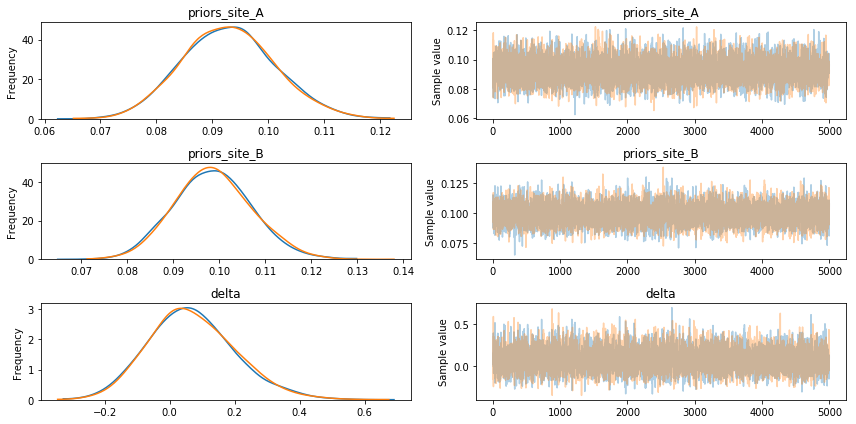

In [21]:
pm.traceplot(trace_bernoulli)
plt.show()

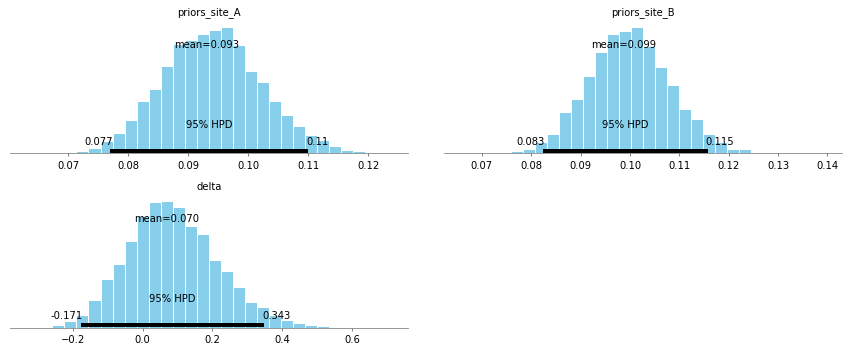

In [22]:
pm.plot_posterior(trace_bernoulli, color='#87ceeb')
plt.show()

In [27]:
print("This is the probability that site_A converstion rate is higher than site B")
print((trace_bernoulli['priors_site_A'] > trace_bernoulli['priors_site_B']).mean())
print("\nThe relative increase of conversion rates between sita B and A: "+str((trace_bernoulli['delta']).mean()))

This is the probability that site_A converstion rate is higher than site B
0.3083

The relative increase of conversion rates between sita B and A: 0.07001136243157416


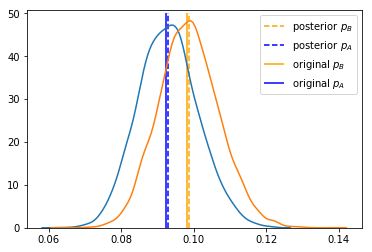

In [28]:
original_conversions_B = site_B_sign_ups[site_B_sign_ups==1].sum() / len(site_B_sign_ups)
original_conversions_A = site_A_sign_ups[site_A_sign_ups==1].sum() / len(site_A_sign_ups)


sns.kdeplot(trace_bernoulli['priors_site_A'])
sns.kdeplot(trace_bernoulli['priors_site_B'])
plt.vlines(np.mean(trace_bernoulli['priors_site_B']), 0, 50, linestyle="--", label="posterior $p_B$", color='orange')
plt.vlines(np.mean(trace_bernoulli['priors_site_A']), 0, 50, linestyle="--", label="posterior $p_A$", color='blue')
plt.vlines((original_conversions_B), 0, 50, linestyle="-", label="original $p_B$", color='orange')
plt.vlines((original_conversions_A), 0, 50, linestyle="-", label="original $p_A$", color='blue')
plt.legend()
plt.show()

# Relative Lift - esimating the increase
People often refer to the **Relative Increase** of results as the Relative Lift (pg. 208). This can be calculated as:

$$\frac{(posteriorSamplesA - posteriorSamplesB)} {posteriorSamplesB} $$ , where (A>B).

Let go back to the first problem of this notebook, where we compare two webpages for the same organization, and analyze the probabilibty of conversions (sign-ups to memberships) for each web page.

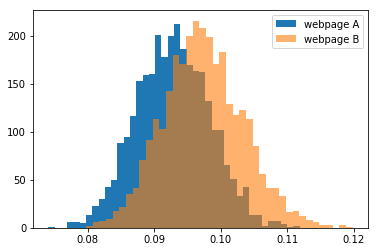

In [30]:
plt.hist(samples_posterior_A, label='webpage A', bins=40)
plt.hist(samples_posterior_B, label='webpage B', bins=40, alpha=0.6)
plt.legend()
plt.show()

In [31]:
print ("Probability that site A has higher conversion rates then site B is only:")
print((samples_posterior_A > samples_posterior_B).mean())

Probability that site A has higher conversion rates then site B is only:
0.295


We'll pass the posteriors through our function to compute the **relative increase** pairwise. 

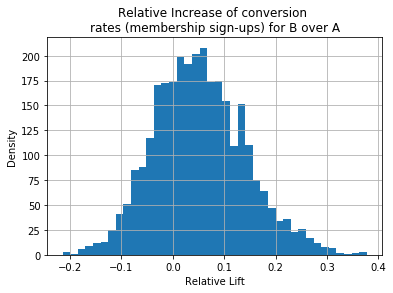

In [32]:
def relative_increase(a,b):
    return ((b-a)/a)          #we changed the the order because in this case B > A

posterior_rel_increase = relative_increase(samples_posterior_A, samples_posterior_B)
plt.hist(posterior_rel_increase, bins=40)
plt.ylabel('Density')
plt.xlabel('Relative Lift')
plt.grid()
plt.title("Relative Increase of conversion \nrates (membership sign-ups) for B over A")
plt.show()

In [33]:
print("The median Relative Increase is "+ str(round(np.median(posterior_rel_increase), 3)*100)+"%")
print("\nThere is a "+str(np.round((posterior_rel_increase > 0.05).mean(),3))+ " chance that the relative increase \
of webpage B's converstion rate over A's conversion rate is over 5%")
print("There is a "+str(np.round((posterior_rel_increase > 0.1).mean(),3))+ " chance that the relative increase \
of webpage B's converstion rate over A's conversion rate is over 10%")
print("There is a "+str(np.round((posterior_rel_increase > 0.2).mean(),3))+ " chance that the relative increase \
of webpage B's converstion rate over A's conversion rate is over 20%")

The median Relative Increase is 4.8%

There is a 0.488 chance that the relative increase of webpage B's converstion rate over A's conversion rate is over 5%
There is a 0.281 chance that the relative increase of webpage B's converstion rate over A's conversion rate is over 10%
There is a 0.057 chance that the relative increase of webpage B's converstion rate over A's conversion rate is over 20%


We've tackled two things:

**The Binary problem:**
As we can see, the probability that webpage B's converstion rates are higher than A's is only about 70%. 

**The Continuous problem:**
If B is indeed larger, then it is not by much: only about 48% chance that B's conversion rates are higher than A's by more than 5%. 